<a href="https://colab.research.google.com/github/alaeddinehamroun/Natural-Language-Processing/blob/main/BBC_News_archive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The [BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview), which contains 2225 examples of news articles with their respective categories (labels).

In [71]:
import csv
import numpy as np
import tensorflow as tf
# This class allows to vectorize a text corpus, by tuning each text into either a sequence of integers
# (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary,
# based on word count, based on tf-idf...
from tensorflow.keras.preprocessing.text import Tokenizer
# Pads sequences to the same length.
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [35]:
with open("./data/bbc-text.csv", 'r') as csvfile:
  print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
  print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

Each data point is composed of the category of the news article followed by a comma and then the actual text of the article.

## Defining global variables

In [52]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

## Removeing Stopwords
Stopwords rarely provide useful information for the classification process.

In [53]:
def remove_stopwords(sentence):
  """
  Removes a list of stopwords
  
  Args:
    sentence (string): sentence to remove the stopwords from.
  Returns:
    sentence (string): lowercase sentence without the stopwords.
  """
  # List of stopwords
  stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

  # Sentence converted to lowercase-only
  sentence = sentence.lower()

  words = sentence.split()
  no_words = [w for w in words if w not in stopwords]
  sentence = " ".join(no_words)

  return sentence

## Reading the raw data

In [54]:
def parse_data_from_file(filename):
  """
  Extracts sentences and labels from a CSV file

  Args:
    sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
  """
  sentences = []
  labels = []
  with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    for row in reader:
      labels.append(row[0])
      sentence = row[1]
      sentence = remove_stopwords(sentence)
      sentences.append(sentence)
    return sentences, labels

In [55]:
sentences, labels = parse_data_from_file("./data/bbc-text.csv")

In [56]:
print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset.

First sentence has 436 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


## Training - Validation Split

In [57]:
def train_val_split(sentences, labels, training_split):
  """
  Splits the dataset into trainig and validation sets
  Args:
    sentences (list of string): lower-cased sentences without stopwords
    lebels (list of string): list of labels
    training split (float): proportion of the dataset to convert to include in the train set
  Returns:
    train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
  """
  # Compute the number of sentences that will be used for training (should be an integer)
  train_size = int(len(sentences)*training_split)

  # Split the sentences and labels into train/validation splits
  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]

  validation_sentences = sentences[train_size:]
  validation_labels = labels[train_size:]

  return train_sentences, validation_sentences, train_labels, validation_labels

In [58]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

In [59]:
print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.


## Tokenization
To tokenize the sentences of the dataset.

In [60]:
def fit_tokenizer(train_sentences, num_words, oov_token):
  """
  Instantiates the Tokenizer class
  Args:
    sentences (list): lower-cased sentences witout stopwords
  Returns:
    tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
  """
  # Instantiate the Tokenizer class by passing in the oov_token argument
  tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
  # Fit on the sentences
  tokenizer.fit_on_texts(train_sentences)
  
  return tokenizer

In [61]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

In [62]:
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27285 words

<OOV> token included in vocabulary


In [64]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
  """
  Generates an array of token sequences and pads them to the same length

  Args:
    sentences (list of string): list of sentences to tokenize and pad
    tokenizer (object): Tokenizer instance containing the word-index dictionary
    padding (string): type of padding to use
    maxlen (int): maximum length of the token sequence
  Returns:
    padded_sequences (array of int): tokenized sentences padded to the same length
  """
  # Convert sentences to sequences
  sequences = tokenizer.texts_to_sequences(sentences)
  # Pad the sequences using the post padding strategy
  padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

  return padded_sequences

In [65]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

In [66]:
def tokenize_labels(all_labels, split_labels):
  """
  Tokenizes the labels

  Args:
    all_labels (list of string): labels to generate the word-index from
    split_labels (list of string): labels to tokenize
  Returns:
    label_seq_np (array of int): tokenized labels
  """

  # Instantiate the Tokenizer class
  # No need to pass additional arguments since you will be tokenizing the labels
  label_tokenizer = Tokenizer()

  # Fit the tokenizer on all the labels
  label_tokenizer.fit_on_texts(all_labels)
    
  # Convert labels to sequences
  label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
  # Convert sequences to a numpy array
  label_seq_np = np.array(label_seq) - 1
    
  return label_seq_np

In [67]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

In [68]:
print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [4]]

First 5 labels of the validation set should look like this:
[[4]
 [3]
 [2]
 [0]
 [0]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)



## Selecting the model for text classification

In [69]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
      num_words (int): size of the vocabulary for the Embedding layer input
      embedding_dim (int): dimensionality of the Embedding layer output
      maxlen (int): length of the input sequences
    
    Returns:
      model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
        
    model = tf.keras.Sequential([ 
      tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(24, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [70]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 3s 6ms/step - loss: 1.5988 - accuracy: 0.2826 - val_loss: 1.5817 - val_accuracy: 0.4539
Epoch 2/30
56/56 [==============================] - 0s 4ms/step - loss: 1.5505 - accuracy: 0.4393 - val_loss: 1.5072 - val_accuracy: 0.4449
Epoch 3/30
56/56 [==============================] - 0s 4ms/step - loss: 1.4295 - accuracy: 0.5129 - val_loss: 1.3490 - val_accuracy: 0.5461
Epoch 4/30
56/56 [==============================] - 0s 4ms/step - loss: 1.2200 - accuracy: 0.6320 - val_loss: 1.1292 - val_accuracy: 0.6899
Epoch 5/30
56/56 [==============================] - 0s 4ms/step - loss: 0.9706 - accuracy: 0.7820 - val_loss: 0.9012 - val_accuracy: 0.7798
Epoch 6/30
56/56 [==============================] - 0s 4ms/step - loss: 0.7353 - accuracy: 0.8742 - val_loss: 0.7046 - val_accuracy: 0.8697
Epoch 7/30
56/56 [==============================] - 0s 7ms/step - loss: 0.5476 - accuracy: 0.9230 - val_loss: 0.5573 - val_accuracy: 0.8787
Epoch 8/30
56/56 [==

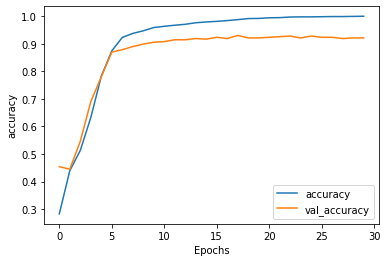

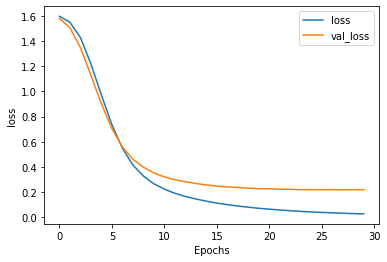

In [72]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history[f'val_{metric}'])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, f'val_{metric}'])
  plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")